In [7]:
# IMport lib
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import random
import torch.nn.functional as F
from collections import namedtuple, deque
from gymnasium.wrappers import RecordVideo
import math
from tqdm import tqdm
!pip install swig
!pip install "gymnasium[box2d]"

cuda


Training Progress: 100%|██████████| 1000/1000 [30:21<00:00,  1.82s/it]


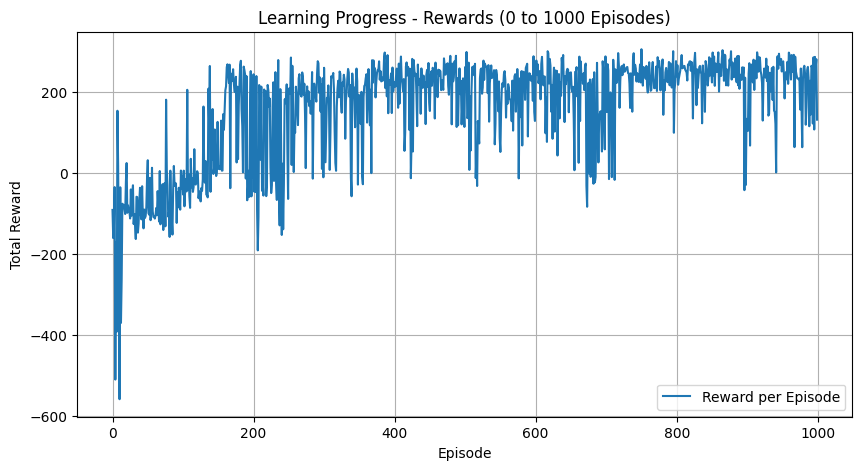

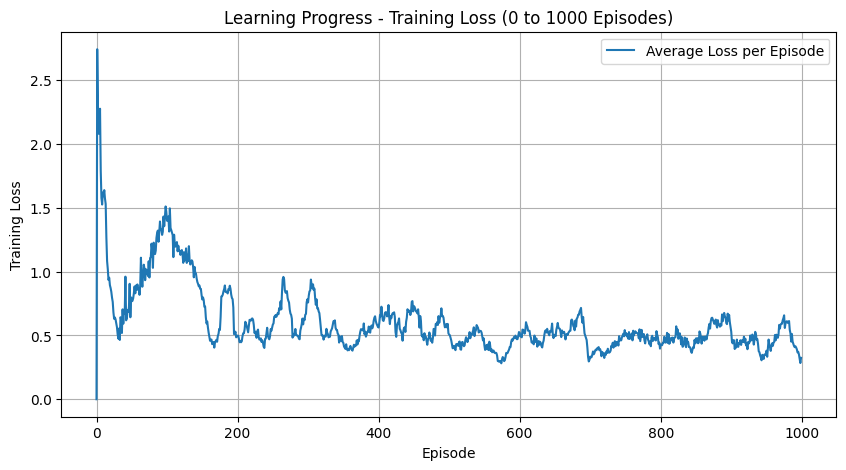

In [ ]:
# Environment and Parameters
Environment = gym.make("LunarLander-v3", continuous=False, gravity=-10.0, enable_wind=False, wind_power=15.0, turbulence_power=1.5)
np.random.seed(42)
torch.manual_seed(42)
BATCHSIZE = 128
GAMMA = 0.99
EPSSTART = 1.0
EPSEND = 0.01
EPSDecay = 1000
LR = 1e-4
TAU = 0.005

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# QNetwork
class DQNetwork(nn.Module):
  def __init__(self, NState, NAction):
    super(DQNetwork, self).__init__()
    self.layer1 = nn.Linear(NState, 128)
    self.layer2 = nn.Linear(128, 128)
    self.layer3 = nn.Linear(128, NAction)
  def forward(self, x):
    x = F.relu(self.layer1(x))
    x = F.relu(self.layer2(x))
    return self.layer3(x)

# Define Replay
Transition = namedtuple('Transition',('state', 'action', 'NextState', 'reward', 'done'))
class ReplayMemory:
  def __init__(self, capacity):
    self.memory = deque([], maxlen=capacity)

  def push(self, *args):
    self.memory.append(Transition(*args))

  def sample(self, batch_size):
    return random.sample(self.memory, batch_size)

  def __len__(self):
    return len(self.memory)

# Agent
class DQNAgent:
  def __init__(self, NState, NAction):
    self.NState = NState
    self.NAction = NAction
    self.Memory = ReplayMemory(10000)
    self.PolicyNet = DQNetwork(NState, NAction).to(device)
    self.TargetNet = DQNetwork(NState, NAction).to(device)
    self.TargetNet.load_state_dict(self.PolicyNet.state_dict())
    self.TargetNet.eval()
    self.optimizer = optim.Adam(self.PolicyNet.parameters(), lr=LR, amsgrad=True)
    self.StepDone = 0

  def SelectAction(self, State):
    Sample = random.random()
    EPS_threshold = EPSEND + (EPSSTART - EPSEND) * \
        math.exp(-1. * self.StepDone / EPSDecay)
    self.StepDone += 1
    if Sample > EPS_threshold:
      with torch.no_grad():
        return self.PolicyNet(State).max(1)[1].view(1, 1)
    else:
      return torch.tensor([[Environment.action_space.sample()]],
                          device=device, dtype=torch.long)

  def StoreTransition(self, State, Action, NextState, Reward, Done):
    self.Memory.push(State, Action, NextState, Reward, Done)

  def Qptimizer(self):
    if len(self.Memory) < BATCHSIZE:
      return 0

    Transitions = self.Memory.sample(BATCHSIZE)

    BATCH = Transition(*zip(*Transitions))

    NonResult = torch.tensor(tuple(map(lambda x: x is not None,
            BATCH.NextState)), device=device, dtype=torch.bool)
    NonResultNext = torch.cat([y for y in BATCH.NextState
                                        if y is not None])
    StateBatch = torch.cat(BATCH.state)
    ActionBatch = torch.cat(BATCH.action)
    RewardBatch = torch.cat(BATCH.reward)
    DoneBATCH = torch.tensor(BATCH.done, dtype=torch.float32, device=device)

    StateActionValues = self.PolicyNet(StateBatch).gather(1, ActionBatch)

    NextActionValues = torch.zeros(BATCHSIZE, device=device)
    with torch.no_grad():
      NextActionValues[NonResult] = self.TargetNet(NonResultNext).max(1)[0]
    # Compute the expected Q values
    ExpectedQValues = (NextActionValues * GAMMA) + RewardBatch

    # Compute Huber loss
    Criterion = nn.SmoothL1Loss()
    Loss = Criterion(StateActionValues, ExpectedQValues.unsqueeze(1))

    # Optimize the model
    self.optimizer.zero_grad()
    Loss.backward()
    torch.nn.utils.clip_grad_value_(self.PolicyNet.parameters(), 100)
    self.optimizer.step()
    return Loss.item()

  def UpdateTargetNet(self):
    TargetNetStateDict = self.TargetNet.state_dict()
    PolicyNetStateDict = self.PolicyNet.state_dict()
    for Key in PolicyNetStateDict:
      TargetNetStateDict[Key] = TAU * PolicyNetStateDict[Key] + (1 - TAU) * TargetNetStateDict[Key]
    self.TargetNet.load_state_dict(TargetNetStateDict)

Episodes = 1000

def TrainAgent(Episodes):
  NState = Environment.observation_space.shape[0]
  NAction = Environment.action_space.n
  Agent = DQNAgent(NState, NAction)
  Rewards = []
  Losses = []

  for Episode in tqdm(range(Episodes), desc="Training Progress"):
    State, _ = Environment.reset()
    State = torch.tensor(State, dtype=torch.float32, device=device).unsqueeze(0)
    TotalReward = 0
    EpisodeLoss = []
    done = False

    while not done:
      Action = Agent.SelectAction(State)
      NextState, Reward, Terminated, Truncated, _ = Environment.step(Action.item())
      Reward = torch.tensor([Reward], device=device)
      done = Terminated or Truncated

      NextState = None if done else torch.tensor(NextState, dtype=torch.float32, device=device).unsqueeze(0)
      Agent.StoreTransition(State, Action, NextState, Reward, done)

      State = NextState
      TotalReward += Reward.item()

      Loss = Agent.Qptimizer()
      if Loss > 0:
        EpisodeLoss.append(Loss)
      Agent.UpdateTargetNet()

    Rewards.append(TotalReward)
    Losses.append(np.mean(EpisodeLoss) if len(EpisodeLoss) > 0 else 0)
    # print(f"Episode: {Episode+1}/{Episodes}, Reward: {TotalReward:.2f}, AVG Loss:{Losses[-1]:.4f}")

  Environment.close()
  return Agent, Rewards, Losses

def PLOT(Rewards, Losses):
  plt.figure(figsize=(10, 5))
  plt.plot(Rewards, label="Reward per Episode")
  plt.xlabel("Episode")
  plt.ylabel("Total Reward")
  plt.title("Learning Progress - Rewards (0 to 1000 Episodes)")
  plt.legend()
  plt.grid()
  plt.savefig("rewards_plot.png")
  plt.show()

  plt.figure(figsize=(10, 5))
  plt.plot(Losses, label="Average Loss per Episode")
  plt.xlabel("Episode")
  plt.ylabel("Training Loss")
  plt.title("Learning Progress - Training Loss (0 to 1000 Episodes)")
  plt.legend()
  plt.grid()
  plt.savefig("loss_plot.png")
  plt.show()

def RECORD(Agent):
  environment = gym.make("LunarLander-v3", render_mode="rgb_array")
  environment = RecordVideo(environment, video_folder="videos", episode_trigger=lambda x: True)
  State, _ = environment.reset()
  State = torch.tensor(State, dtype=torch.float32, device=device).unsqueeze(0)
  done = False
  while not done:
    Action = Agent.SelectAction(State)
    NextState, _, Terminated, Truncated, _ = environment.step(Action.item())
    done = Terminated or Truncated
    State = torch.tensor(NextState, dtype=torch.float32, device=device).unsqueeze(0) if not done else None
  environment.close()

if __name__ == "__main__":
  Agent, Rewards, Losses = TrainAgent(Episodes)
  PLOT(Rewards, Losses)
  RECORD(Agent)
  torch.save(Agent.PolicyNet.state_dict(), "model.pth")


Using device:cpu


Training Progress: 100%|██████████| 1000/1000 [1:59:20<00:00,  7.16s/it]


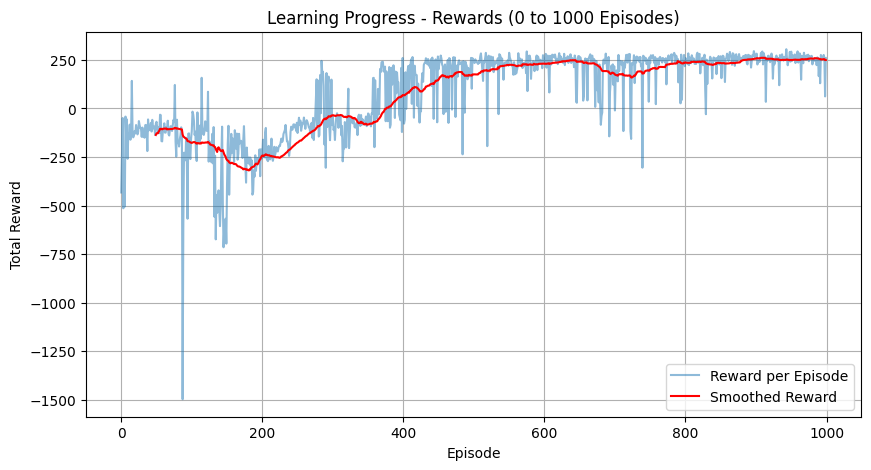

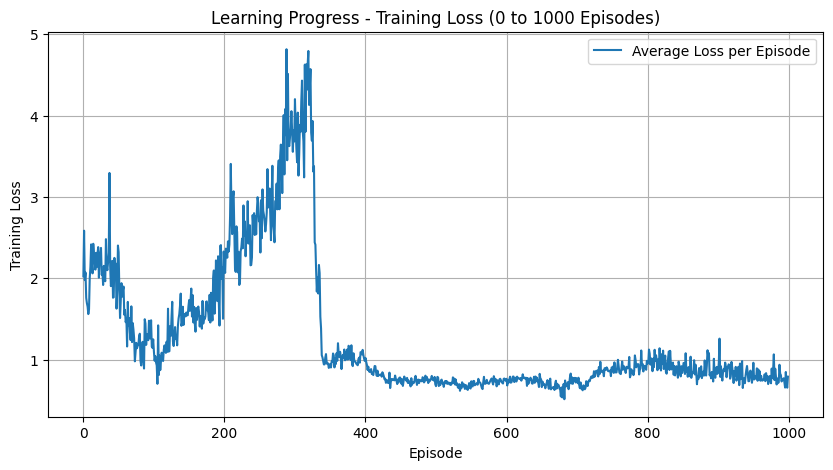

Average Test Reward over 100 episodes: 95.61


In [ ]:
# Environment and Parameters
Environment = gym.make("LunarLander-v3", continuous=False, gravity=-10.0, enable_wind=False, wind_power=15.0, turbulence_power=1.5)
np.random.seed(42)
torch.manual_seed(42)
BATCHSIZE = 64
GAMMA = 0.99
EPSSTART = 1.0
EPSEND = 0.05
EPSDecay = 1000
LR = 1e-4
TAU = 0.005
TARGET_UPDATE = 50

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device:{device}")

# QNetwork
class DQNetwork(nn.Module):
  def __init__(self, NState, NAction):
    super(DQNetwork, self).__init__()
    self.layer1 = nn.Linear(NState, 512)
    self.layer2 = nn.Linear(512, 256)
    self.layer3 = nn.Linear(256, 128)
    self.layer4 = nn.Linear(128, NAction)
  def forward(self, x):
    x = F.relu(self.layer1(x))
    x = F.relu(self.layer2(x))
    x = F.relu(self.layer3(x))
    return self.layer4(x)

# Define Replay
Transition = namedtuple('Transition',('state', 'action', 'NextState', 'reward', 'done'))
class ReplayMemory:

    def __init__(self, capacity):
        self.memory = deque([], maxlen=100000)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# Agent
class DQNAgent:
  def __init__(self, NState, NAction):
    self.NState = NState
    self.NAction = NAction
    self.Memory = ReplayMemory(100000)
    self.PolicyNet = DQNetwork(NState, NAction).to(device)
    self.TargetNet = DQNetwork(NState, NAction).to(device)
    self.TargetNet.load_state_dict(self.PolicyNet.state_dict())
    self.TargetNet.eval()
    self.optimizer = optim.Adam(self.PolicyNet.parameters(), lr=LR, amsgrad=True)
    self.StepDone = 0

  def get_epsilon(self):
    return EPSEND + (EPSSTART - EPSEND) * math.exp(-1. * self.StepDone / EPSDecay)

  def SelectAction(self, State):
    Sample = random.random()
    EPS_threshold = self.get_epsilon()
    self.StepDone += 1
    if Sample > EPS_threshold:
      with torch.no_grad():
        return self.PolicyNet(State).max(1)[1].view(1, 1)
    else:
      return torch.tensor([[Environment.action_space.sample()]], device=device, dtype=torch.long)
      #return torch.tensor([[random.randrange(self.n_actions)]], device=device, dtype=torch.long)  # 探索：随机动作

  def StoreTransition(self, State, Action, NextState, Reward, Done):
    Reward = torch.tensor([Reward.item()], device=device)
    self.Memory.push(State, Action, NextState, Reward, Done)

  def Qptimizer(self):
    if len(self.Memory) < BATCHSIZE:
      return 0

    Transitions = self.Memory.sample(BATCHSIZE)
    BATCH = Transition(*zip(*Transitions))

    NonResult = torch.tensor(tuple(map(lambda x: x is not None, BATCH.NextState)), device=device, dtype=torch.bool)
    NonResultNext = torch.cat([y for y in BATCH.NextState if y is not None])
    StateBatch = torch.cat(BATCH.state)
    ActionBatch = torch.cat(BATCH.action)
    RewardBatch = torch.cat(BATCH.reward)

    StateActionValues = self.PolicyNet(StateBatch).gather(1, ActionBatch)

    NextActionValues = torch.zeros(BATCHSIZE, device=device)
    with torch.no_grad():
      next_actions = self.PolicyNet(NonResultNext).max(1)[1]
      NextActionValues[NonResult] = self.TargetNet(NonResultNext).gather(1, next_actions.unsqueeze(1)).squeeze(1)

    # Compute the expected Q values
    ExpectedQValues = RewardBatch + GAMMA * NextActionValues

    # Compute Huber loss
    Criterion = nn.SmoothL1Loss()
    Loss = Criterion(StateActionValues, ExpectedQValues.unsqueeze(1))

    # Optimize the model
    self.optimizer.zero_grad()
    Loss.backward()
    torch.nn.utils.clip_grad_norm_(self.PolicyNet.parameters(), max_norm=5)
    self.optimizer.step()
    return Loss.item()

  def UpdateTargetNet(self):
    if self.StepDone % TARGET_UPDATE == 0:
      self.TargetNet.load_state_dict(self.PolicyNet.state_dict())
    else:
      TargetNetStateDict = self.TargetNet.state_dict()
      PolicyNetStateDict = self.PolicyNet.state_dict()
      for Key in PolicyNetStateDict:
        TargetNetStateDict[Key] = TAU * PolicyNetStateDict[Key] + (1 - TAU) * TargetNetStateDict[Key]
        self.TargetNet.load_state_dict(TargetNetStateDict)

Episodes = 1000

def TrainAgent(Episodes):
  NState = Environment.observation_space.shape[0]
  NAction = Environment.action_space.n
  Agent = DQNAgent(NState, NAction)
  Rewards = []
  Losses = []
  best_avg = -np.inf

  for Episode in tqdm(range(Episodes), desc="Training Progress"):
    State, _ = Environment.reset()
    State = torch.tensor(State, dtype=torch.float32, device=device).unsqueeze(0)
    TotalReward = 0
    EpisodeLoss = []
    done = False

    while not done:
      Action = Agent.SelectAction(State)
      NextState, Reward, Terminated, Truncated, _ = Environment.step(Action.item())
      if NextState is not None:
        x, y = NextState[0], NextState[1]
        v_x, v_y = NextState[2], NextState[3]
        angle = NextState[4]
        distance_bonus = -0.1 * (x**2 + y**2)
        speed_bonus = -0.1 * (v_x**2 + v_y**2)
        angle_bonus = -0.2 * (angle**2)
        Reward += distance_bonus + speed_bonus + angle_bonus

      Reward = torch.tensor([Reward], device=device)
      done = Terminated or Truncated
      NextState = None if done else torch.tensor(NextState, dtype=torch.float32, device=device).unsqueeze(0)
      Agent.StoreTransition(State, Action, NextState, Reward, done)

      State = NextState
      TotalReward += Reward.item()

      Loss = Agent.Qptimizer()
      if Loss > 0:
        EpisodeLoss.append(Loss)
      Agent.UpdateTargetNet()

    Rewards.append(TotalReward)
    Losses.append(np.mean(EpisodeLoss) if len(EpisodeLoss) > 0 else 0)

    if Episode >= 50:
      avg_last_10 = np.mean(Rewards[-10:])
      if avg_last_10 > best_avg:
        best_avg = avg_last_10
    elif Episode > 100 and avg_last_10 < best_avg * 0.8:
      print(f"Early stop at Episode {Episode}")
      break

  Environment.close()
  return Agent, Rewards, Losses

def PLOT(Rewards, Losses):
  window_size = 50
  rewards_smoothed = np.convolve(Rewards, np.ones(window_size)/window_size, mode='valid')
  plt.figure(figsize=(10, 5))
  plt.plot(Rewards, label="Reward per Episode", alpha=0.5)
  plt.plot(range(window_size-1, len(Rewards)), rewards_smoothed, label="Smoothed Reward", color='red')
  plt.xlabel("Episode")
  plt.ylabel("Total Reward")
  plt.title("Learning Progress - Rewards (0 to 1000 Episodes)")
  plt.legend()
  plt.grid()
  plt.savefig("rewards_plot.png")
  plt.show()

  plt.figure(figsize=(10, 5))
  plt.plot(Losses, label="Average Loss per Episode")
  plt.xlabel("Episode")
  plt.ylabel("Training Loss")
  plt.title("Learning Progress - Training Loss (0 to 1000 Episodes)")
  plt.legend()
  plt.grid()
  plt.savefig("loss_plot.png")
  plt.show()

def RECORD(Agent):
  environment = gym.make("LunarLander-v3", render_mode="rgb_array")
  environment = RecordVideo(environment, video_folder="videos", episode_trigger=lambda x: True)
  State, _ = environment.reset()
  State = torch.tensor(State, dtype=torch.float32, device=device).unsqueeze(0)
  done = False
  while not done:
    Action = Agent.SelectAction(State)
    NextState, _, Terminated, Truncated, _ = environment.step(Action.item())
    done = Terminated or Truncated
    State = torch.tensor(NextState, dtype=torch.float32, device=device).unsqueeze(0) if not done else None
  environment.close()

def TestAgent(agent, episodes=100):
  test_rewards = []
  for _ in range(episodes):
    state, _ = Environment.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    total_reward = 0
    done = False
    while not done:
      with torch.no_grad():
        action = agent.PolicyNet(state).max(1)[1].view(1, 1)
        next_state, reward, terminated, truncated, _ = Environment.step(action.item())
        total_reward += reward
        done = terminated or truncated
        state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0) if not done else None
      test_rewards.append(total_reward)
  avg_reward = np.mean(test_rewards)
  print(f"Average Test Reward over {episodes} episodes: {avg_reward:.2f}")
  return avg_reward

if __name__ == "__main__":
  Agent, Rewards, Losses = TrainAgent(Episodes)
  PLOT(Rewards, Losses)
  RECORD(Agent)
  TestAgent(Agent)
  torch.save(Agent.PolicyNet.state_dict(), "model.pth")


Using device:cuda


Training Progress:  10%|█         | 100/1000 [07:34<1:25:53,  5.73s/it]

Episode 100: Avg Reward (last 100) = -11.43, Avg Loss = 1.1100


Training Progress:  20%|██        | 200/1000 [14:24<38:30,  2.89s/it]

Episode 200: Avg Reward (last 100) = 136.87, Avg Loss = 0.5087


Training Progress:  30%|███       | 300/1000 [18:57<22:00,  1.89s/it]

Episode 300: Avg Reward (last 100) = 227.41, Avg Loss = 0.4580


Training Progress:  40%|████      | 400/1000 [23:17<22:43,  2.27s/it]

Episode 400: Avg Reward (last 100) = 241.73, Avg Loss = 0.5822


Training Progress:  50%|█████     | 500/1000 [27:13<19:37,  2.35s/it]

Episode 500: Avg Reward (last 100) = 242.28, Avg Loss = 0.6576


Training Progress:  60%|██████    | 600/1000 [31:13<16:00,  2.40s/it]

Episode 600: Avg Reward (last 100) = 246.51, Avg Loss = 0.6188


Training Progress:  70%|███████   | 700/1000 [34:42<11:15,  2.25s/it]

Episode 700: Avg Reward (last 100) = 238.42, Avg Loss = 0.5947


Training Progress:  80%|████████  | 800/1000 [38:02<06:08,  1.84s/it]

Episode 800: Avg Reward (last 100) = 259.17, Avg Loss = 0.6123


Training Progress:  90%|█████████ | 900/1000 [41:07<03:18,  1.99s/it]

Episode 900: Avg Reward (last 100) = 263.42, Avg Loss = 0.6234


Training Progress: 100%|██████████| 1000/1000 [44:10<00:00,  2.65s/it]

Episode 1000: Avg Reward (last 100) = 265.46, Avg Loss = 0.6170


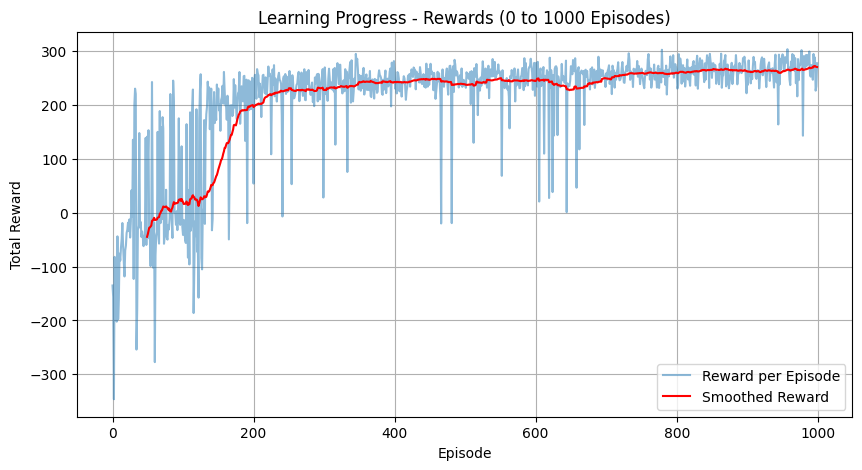

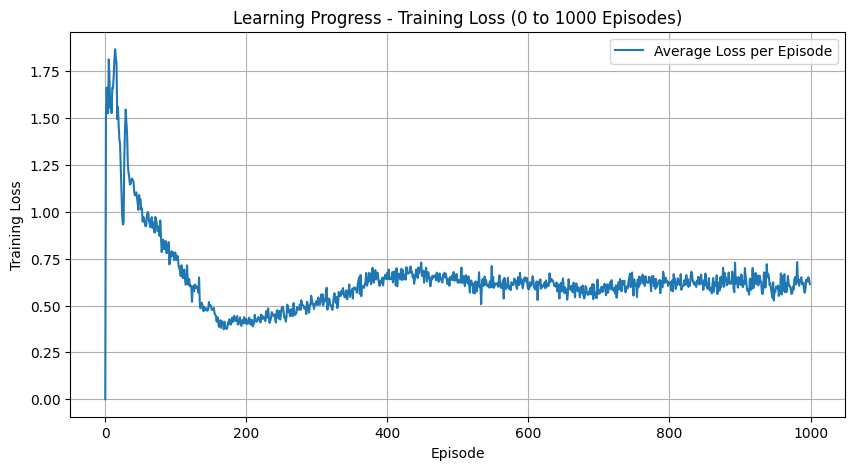

Average Test Reward over 100 episodes: 130.20


In [7]:
# Environment and Parameters
Environment = gym.make("LunarLander-v3", continuous=False, gravity=-10.0, enable_wind=False, wind_power=15.0, turbulence_power=1.5)
np.random.seed(42)
torch.manual_seed(42)
BATCHSIZE = 128
GAMMA = 0.99
EPSSTART = 1.0
EPSEND = 0.05
EPSDecay = 2000
LR = 1e-4
TAU = 0.005
TARGET_UPDATE = 50

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device:{device}")

# QNetwork
class DQNetwork(nn.Module):
  def __init__(self, NState, NAction):
    super(DQNetwork, self).__init__()
    self.layer1 = nn.Linear(NState, 512)
    self.layer2 = nn.Linear(512, 256)
    self.layer3 = nn.Linear(256, 128)
    self.layer4 = nn.Linear(128, NAction)
  def forward(self, x):
    x = F.relu(self.layer1(x))
    x = F.relu(self.layer2(x))
    x = F.relu(self.layer3(x))
    return self.layer4(x)

# Define Replay
Transition = namedtuple('Transition',('state', 'action', 'NextState', 'reward', 'done'))
class ReplayMemory:
  def __init__(self, capacity):
    self.memory = deque([], maxlen=100000)

  def push(self, *args):
    self.memory.append(Transition(*args))

  def sample(self, batch_size):
    return random.sample(self.memory, batch_size)

  def __len__(self):
    return len(self.memory)

# Agent
class DQNAgent:
  def __init__(self, NState, NAction):
    self.NState = NState
    self.NAction = NAction
    self.Memory = ReplayMemory(100000)
    self.PolicyNet = DQNetwork(NState, NAction).to(device)
    self.TargetNet = DQNetwork(NState, NAction).to(device)
    self.TargetNet.load_state_dict(self.PolicyNet.state_dict())
    self.TargetNet.eval()
    self.optimizer = optim.Adam(self.PolicyNet.parameters(), lr=LR, amsgrad=True)
    self.StepDone = 0

  def get_epsilon(self):
    return EPSEND + (EPSSTART - EPSEND) * math.exp(-1. * self.StepDone / EPSDecay)

  def SelectAction(self, State):
    Sample = random.random()
    EPS_threshold = self.get_epsilon()
    self.StepDone += 1
    if Sample > EPS_threshold:
      with torch.no_grad():
        return self.PolicyNet(State).max(1)[1].view(1, 1)
    else:
      return torch.tensor([[Environment.action_space.sample()]], device=device, dtype=torch.long)

  def StoreTransition(self, State, Action, NextState, Reward, Done):
    Reward = torch.tensor([Reward.item()], device=device)
    self.Memory.push(State, Action, NextState, Reward, Done)

  def Qptimizer(self):
    if len(self.Memory) < BATCHSIZE:
      return 0

    Transitions = self.Memory.sample(BATCHSIZE)
    BATCH = Transition(*zip(*Transitions))

    NonResult = torch.tensor(tuple(map(lambda x: x is not None, BATCH.NextState)), device=device, dtype=torch.bool)
    NonResultNext = torch.cat([y for y in BATCH.NextState if y is not None])
    StateBatch = torch.cat(BATCH.state)
    ActionBatch = torch.cat(BATCH.action)
    RewardBatch = torch.cat(BATCH.reward)

    StateActionValues = self.PolicyNet(StateBatch).gather(1, ActionBatch)

    NextActionValues = torch.zeros(BATCHSIZE, device=device)
    with torch.no_grad():
      next_actions = self.PolicyNet(NonResultNext).max(1)[1]
      next_qvalues = self.TargetNet(NonResultNext).gather(1, next_actions.unsqueeze(1)).squeeze(1)
      NextActionValues[NonResult] = next_qvalues

    # Compute the expected Q values
    ExpectedQValues = RewardBatch + GAMMA * NextActionValues

    # Compute Huber loss
    Criterion = nn.SmoothL1Loss()
    Loss = Criterion(StateActionValues, ExpectedQValues.unsqueeze(1))

    # Optimize the model
    self.optimizer.zero_grad()
    Loss.backward()
    torch.nn.utils.clip_grad_norm_(self.PolicyNet.parameters(), max_norm=5)
    self.optimizer.step()
    return Loss.item()

  def UpdateTargetNet(self):
    if self.StepDone % TARGET_UPDATE == 0:
      self.TargetNet.load_state_dict(self.PolicyNet.state_dict())
    else:
      TargetNetStateDict = self.TargetNet.state_dict()
      PolicyNetStateDict = self.PolicyNet.state_dict()
      for Key in PolicyNetStateDict:
        TargetNetStateDict[Key] = TAU * PolicyNetStateDict[Key] + (1 - TAU) * TargetNetStateDict[Key]
        self.TargetNet.load_state_dict(TargetNetStateDict)

Episodes = 1000

def TrainAgent(Episodes):
  NState = Environment.observation_space.shape[0]
  NAction = Environment.action_space.n
  Agent = DQNAgent(NState, NAction)
  Rewards = []
  Losses = []
  best_avg = -np.inf

  for Episode in tqdm(range(Episodes), desc="Training Progress"):
    State, _ = Environment.reset()
    State = torch.tensor(State, dtype=torch.float32, device=device).unsqueeze(0)
    TotalReward = 0
    EpisodeLoss = []
    done = False

    while not done:
      Action = Agent.SelectAction(State)
      NextState, Reward, Terminated, Truncated, _ = Environment.step(Action.item())
      if NextState is not None:
        x, y = NextState[0], NextState[1]
        v_x, v_y = NextState[2], NextState[3]
        angle = NextState[4]
        DistanceR = -0.05 * (x**2 + y**2)
        SpeedR = -0.05 * (v_x**2 + v_y**2)
        AngleR = -0.1 * (angle**2)
        Reward += DistanceR+SpeedR+AngleR

      Reward = torch.tensor([Reward], device=device)
      done = Terminated or Truncated
      NextState = None if done else torch.tensor(NextState, dtype=torch.float32, device=device).unsqueeze(0)
      Agent.StoreTransition(State, Action, NextState, Reward, done)

      State = NextState
      TotalReward += Reward.item()

      Loss = Agent.Qptimizer()
      if Loss > 0:
        EpisodeLoss.append(Loss)
      Agent.UpdateTargetNet()

    Rewards.append(TotalReward)
    Losses.append(np.mean(EpisodeLoss) if len(EpisodeLoss) > 0 else 0)

    if (Episode+1)%100==0:
      Average_Reward100 = np.mean(Rewards[-100:])
      Average_Loss100 = np.mean(Losses[-100:])
      print(f"Episode {Episode + 1}: Avg Reward (last 100) = {Average_Reward100:.2f}, Avg Loss = {Average_Loss100:.4f}")

    if Episode >= 50:
      avg_last_10 = np.mean(Rewards[-10:])
      if avg_last_10 > best_avg:
        best_avg = avg_last_10

  Environment.close()
  return Agent, Rewards, Losses

def PLOT(Rewards, Losses):
  window_size = 50
  rewards_smoothed = np.convolve(Rewards, np.ones(window_size)/window_size, mode='valid')
  plt.figure(figsize=(10, 5))
  plt.plot(Rewards, label="Reward per Episode", alpha=0.5)
  plt.plot(range(window_size-1, len(Rewards)), rewards_smoothed, label="Smoothed Reward", color='red')
  plt.xlabel("Episode")
  plt.ylabel("Total Reward")
  plt.title("Learning Progress - Rewards (0 to 1000 Episodes)")
  plt.legend()
  plt.grid()
  plt.savefig("rewards_plot.png")
  plt.show()

  plt.figure(figsize=(10, 5))
  plt.plot(Losses, label="Average Loss per Episode")
  plt.xlabel("Episode")
  plt.ylabel("Training Loss")
  plt.title("Learning Progress - Training Loss (0 to 1000 Episodes)")
  plt.legend()
  plt.grid()
  plt.savefig("loss_plot.png")
  plt.show()

def RECORD(Agent):
  environment = gym.make("LunarLander-v3", render_mode="rgb_array")
  environment = RecordVideo(environment, video_folder="videos", episode_trigger=lambda x: True)
  State, _ = environment.reset()
  State = torch.tensor(State, dtype=torch.float32, device=device).unsqueeze(0)
  done = False
  while not done:
    Action = Agent.SelectAction(State)
    NextState, _, Terminated, Truncated, _ = environment.step(Action.item())
    done = Terminated or Truncated
    State = torch.tensor(NextState, dtype=torch.float32, device=device).unsqueeze(0) if not done else None
  environment.close()

def TestAgent(agent, episodes=100):
  test_rewards = []
  for _ in range(episodes):
    state, _ = Environment.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    total_reward = 0
    done = False
    while not done:
      with torch.no_grad():
        action = agent.PolicyNet(state).max(1)[1].view(1, 1)
        next_state, reward, terminated, truncated, _ = Environment.step(action.item())
        total_reward += reward
        done = terminated or truncated
        state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0) if not done else None
      test_rewards.append(total_reward)
  avg_reward = np.mean(test_rewards)
  print(f"Average Test Reward over {episodes} episodes: {avg_reward:.2f}")
  return avg_reward

if __name__ == "__main__":
  Agent, Rewards, Losses = TrainAgent(Episodes)
  PLOT(Rewards, Losses)
  RECORD(Agent)
  TestAgent(Agent)
  torch.save(Agent.PolicyNet.state_dict(), "model.pth")
